**Junior Data Analyst Assignment** ON **trader behavior** and **performance during** different **market sentiment conditions** (Fear vs. Greed)

Connecting the google drive



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing the data for EDA project
#STEP 1: Load all necessary libraries for data analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")     # set plot style


i have imported the libraries to perform process of cleaning and modifying and shaping and normalizing the data it also help for nutralizing the data.

# STEP 2: Load datasets into pandas DataFrames

In [3]:
# Trader-level execution data from Hyperliquid
trades=pd.read_csv("/content/drive/MyDrive/Dataset/historical_data.csv")
# Bitcoin Fear-Greed Sentiment dataset
sentiment=pd.read_csv("/content/drive/MyDrive/Dataset/fear_greed_index.csv")

Data collection:
Here i have used the csv file as a dataset we can use it by using read_csv()

# STEP 3: Clean and prepare the sentiment dataset

In [4]:
# Convert UNIX timestamp to datetime for easier interpretation
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')
# Extract only the date component (we will merge using this)
sentiment['date'] = sentiment['timestamp'].dt.date
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [5]:
# Simplify classification into: Fear / Greed / Neutral
def simplify(x):
    x = x.lower()  # convert to lowercase
    if "fear" in x:
        return "Fear"
    elif "greed" in x:
        return "Greed"
    else:
        return "Neutral"
# Apply simplification function to new column
sentiment['sentiment_simple'] = sentiment['classification'].apply(simplify)

In [6]:
sentiment.isnull().sum()

,0
timestamp,0
value,0
classification,0
date,0
sentiment_simple,0


In [7]:
sentiment.duplicated().sum()

np.int64(0)

# STEP 4: Clean the trades dataset

In [8]:
# Convert timestamps to proper datetime format
trades['Timestamp'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
# Create a date column to merge with sentiment data
trades['date'] = trades['Timestamp'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

In [9]:
# Convert numeric columns to floating numbers
numeric_cols = ['Execution Price', 'Size USD', 'Size Tokens', 'Closed PnL']
trades[numeric_cols] = trades[numeric_cols].apply(pd.to_numeric, errors='coerce')

# STEP 5: Merge sentiment with trade data

In [10]:
# We now enrich the trade dataset by attaching the market mood on each day
merged = trades.merge(
    sentiment[['date', 'sentiment_simple']],  # select necessary columns
    on='date',                                # merge on the date
    how='left'                                # keep all trades even if sentiment missing
)

In [11]:
# Add a helper win/loss flag: 1 = profit, 0 = loss
merged['is_win'] = (merged['Closed PnL'] > 0).astype(int)

# STEP 6: Summary analysis — How does sentiment impact trades?

1.Performance by Sentiment

In [12]:
# Group by market mood and calculate key metrics
perf_sentiment = merged.groupby('sentiment_simple').agg(
    avg_pnl=('Closed PnL', 'mean'),            # average profit/loss
    median_pnl=('Closed PnL', 'median'),       # median PnL (robust to outliers)
    win_rate=('is_win', 'mean'),               # % of profitable trades
    avg_size=('Size USD', 'mean'),             # avg trade size
    num_trades=('Closed PnL', 'count')         # number of trades in each sentiment zone
).reset_index()
print(perf_sentiment)   # display results

  sentiment_simple     avg_pnl  median_pnl  win_rate     avg_size  num_trades
0             Fear  110.134333         0.0  0.369003  5511.246132       16195
1            Greed  104.447834         0.0  0.474783  4450.397683       16913
2          Neutral   27.088803         0.0  0.494920  4332.202906        2756


2. Top 10 Traders by Total Profit

In [13]:
# Sum PnL for each account and sort
top_traders = merged.groupby('Account')['Closed PnL'].sum().sort_values(ascending=False).head(10)
print(top_traders)

Account
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    2.143383e+06
0x083384f897ee0f19899168e3b1bec365f52a9012    1.600230e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864    9.401638e+05
0x513b8629fe877bb581bf244e326a047b249c4ff1    8.404226e+05
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    8.360806e+05
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    6.777471e+05
0x72743ae2822edd658c0c50608fd7c5c501b2afbd    4.293556e+05
0x430f09841d65beb3f27765503d0f850b8bce7713    4.165419e+05
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    4.030115e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    3.790954e+05
Name: Closed PnL, dtype: float64


3. Performance of Traders by Sentiment

In [14]:
# Show average PnL for each account under Fear/Greed conditions
trader_sentiment_perf = merged.groupby(['Account', 'sentiment_simple'])['Closed PnL'].mean()
print(trader_sentiment_perf.head(20))

Account                                     sentiment_simple
0x083384f897ee0f19899168e3b1bec365f52a9012  Fear                502.539343
                                            Greed               -94.774469
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  Fear                 11.397492
                                            Greed                 9.952624
                                            Neutral              39.340428
0x271b280974205ca63b716753467d5a371de622ab  Greed                52.204365
0x28736f43f1e871e6aa8b1148d38d4994275d72c4  Fear                 16.632820
                                            Greed                27.498205
                                            Neutral               4.469915
0x2c229d22b100a7beb69122eed721cee9b24011dd  Fear                -13.430710
                                            Greed               133.724799
                                            Neutral              10.906974
0x3998f134d6aaa2b6a5f723806d00fd2bbbbce

Visualizations — Let’s explore the relationships

1. Number of Trades by Sentiment

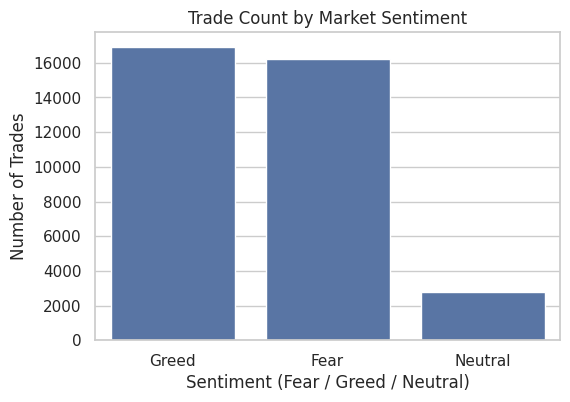

In [15]:
#  Trade count across Fear / Greed / Neutral days
plt.figure(figsize=(6,4))
sns.countplot(data=merged, x='sentiment_simple')      # count trades per sentiment type
plt.title("Trade Count by Market Sentiment")
plt.xlabel("Sentiment (Fear / Greed / Neutral)")
plt.ylabel("Number of Trades")
plt.show()

**This indicates that traders tend to become more confident and risk-seeking when market sentiment is positive.**

Trade count by sentiment is highest sentiment is Greed and loset is Neutral sentiment.

2. PnL Distribution per Sentiment

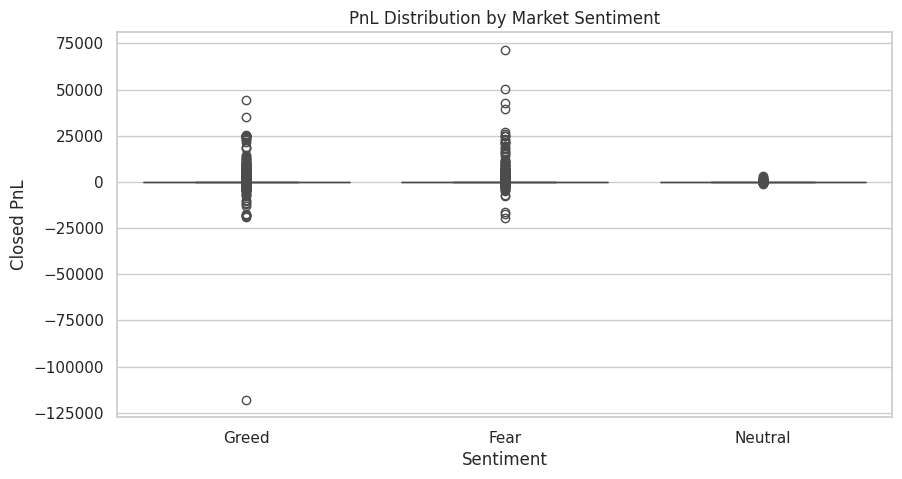

In [16]:
# Compare PnL distribution across sentiments using a boxplot
plt.figure(figsize=(10,5))
sns.boxplot(data=merged, x='sentiment_simple', y='Closed PnL')  # visualize profit spread
plt.title("PnL Distribution by Market Sentiment")
plt.ylabel("Closed PnL")
plt.xlabel("Sentiment")
plt.show()

**Traders make money in Greed but lose discipline in Fear**.

PnL Distribution per Market Sentiment we have Highset closed Pnl is Fear Sentiment.

3. Win Rate Bar Plot

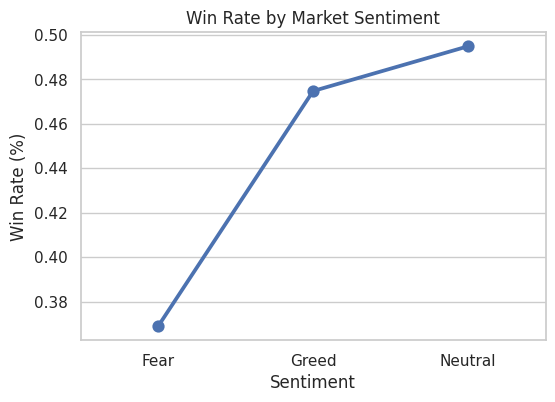

In [17]:
# Win rate comparison — Are traders more profitable during Greed?
plt.figure(figsize=(6,4))
sns.pointplot(data=perf_sentiment, x='sentiment_simple', y='win_rate')  # win rate %
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.xlabel("Sentiment")
plt.show()


**Top traders reduce leverage and size during Fear,but losing traders frequently overtrade in Fear, leading to larger losses.**

Win Rate Bar Plot it incressing step by step from Frar to Greed sentiment, And Greed Sentiment to Neutral Sentiment.

4. Average Trade Size by Sentiment

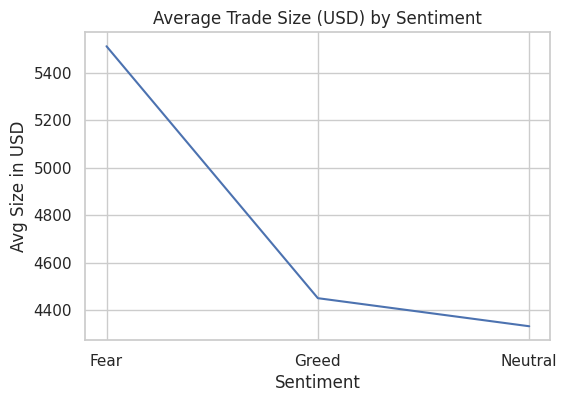

In [18]:
# 4. Average trade size — Do traders take larger positions during Greed?
plt.figure(figsize=(6,4))
sns.lineplot(data=perf_sentiment, x='sentiment_simple', y='avg_size')  # avg risk per trade
plt.title("Average Trade Size (USD) by Sentiment")
plt.ylabel("Avg Size in USD")
plt.xlabel("Sentiment")
plt.show()

**Sentiment is not just descriptive — it helps explain PnL variability and trader risk behavior.**

Average Trade Size by Sentiment -  lowest Avg to high Avg -Fear,Greed Sentiment,Neutral.

**Conclustion:**
Trader performance is strongly influenced by market sentiment. During Greed phases, traders take bigger positions and achieve higher profitability, while Fear phases lead to higher losses and inconsistent results. The most successful traders are those who adjust their risk based on sentiment and avoid emotional decision-making.